In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.table import Table

In [5]:
df = pd.read_csv("GlobalLandTemperaturesByState+(2).csv")

df = df[['dt', 'AverageTemperature', 'State']]

df['dt'] = pd.to_datetime(df['dt'])

df = df[df['dt'].dt.year > 2000]

states = ['Wyoming', 'Nebraska', 'South Dakota']
df = df[df['State'].isin(states)]

print("Filtered dataframe shape:", df.shape)

Filtered dataframe shape: (459, 3)


In [7]:
df_avg = df.groupby('dt', as_index=False)['AverageTemperature'].mean()
df_avg.rename(columns={'AverageTemperature': 'AvgTemperature'}, inplace=True)

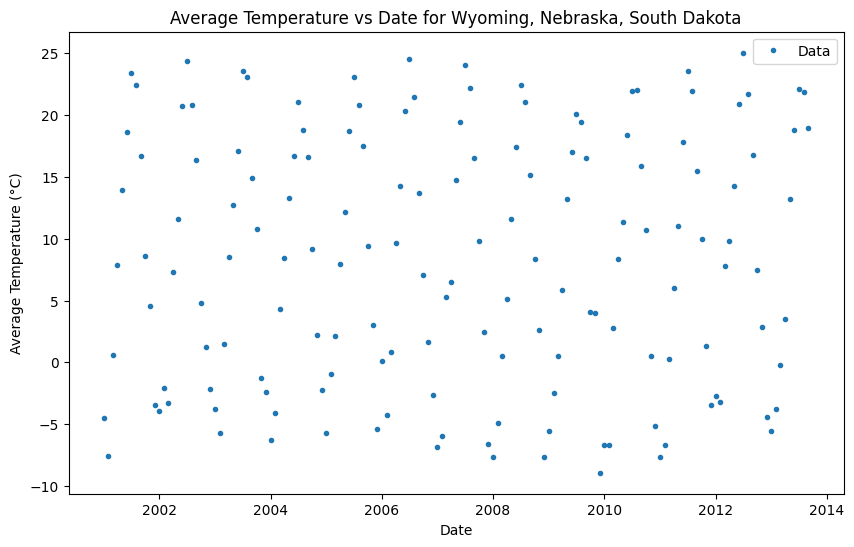

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(df_avg['dt'], df_avg['AvgTemperature'], 'o', markersize=3, label="Data")
plt.xlabel("Date")
plt.ylabel("Average Temperature (°C)")
plt.title("Average Temperature vs Date for Wyoming, Nebraska, South Dakota")
plt.legend()
plt.show()

In [11]:
df_avg['NumericDate'] = df_avg['dt'].dt.year + df_avg['dt'].dt.dayofyear / 365.0

In [13]:
def model(x, A, B, C, D):
    return A * np.sin(B * x + C) + D

In [17]:
A0 = (df_avg['AvgTemperature'].max() - df_avg['AvgTemperature'].min()) / 2
B0 = 2 * np.pi 
C0 = 0
D0 = df_avg['AvgTemperature'].mean()
p0 = [A0, B0, C0, D0]
print("Initial parameter guesses:", p0)

Initial parameter guesses: [16.973166666666668, 6.283185307179586, 0, 8.23681045751634]


In [33]:
xdata = df_avg['NumericDate'].values
ydata = df_avg['AvgTemperature'].values
popt, pcov = curve_fit(model, xdata, ydata, p0=p0)
print("Fitted parameters:", popt)

Fitted parameters: [13.89453444  6.28263912 -0.54835156  8.18527421]


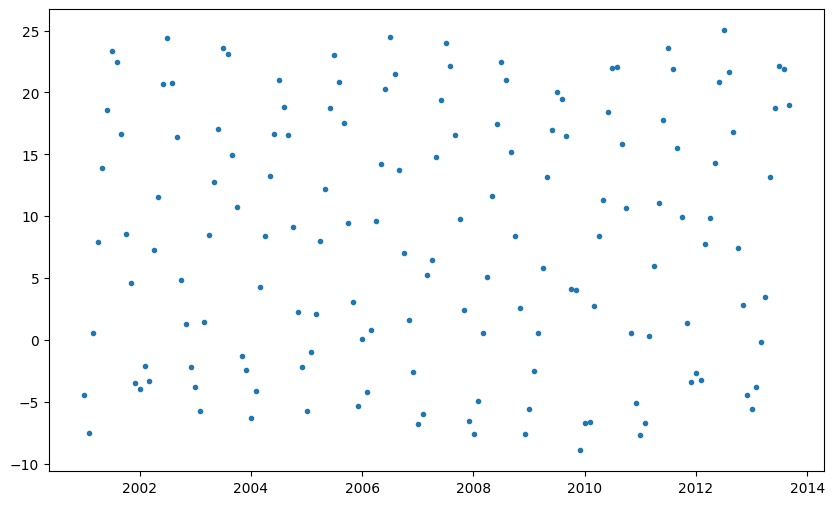

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(df_avg['NumericDate'], ydata, 'o', markersize=3, label="Data")

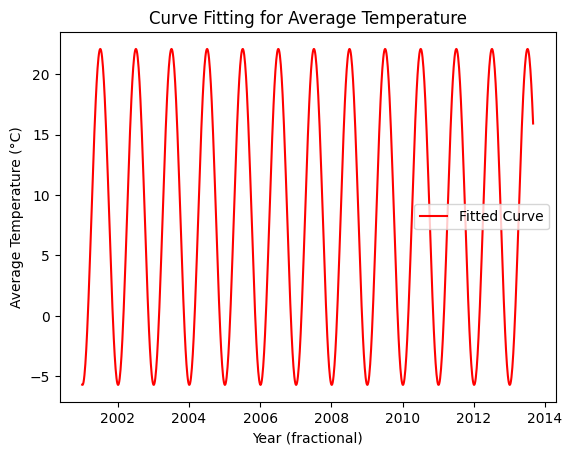

In [37]:
x_fit = np.linspace(xdata.min(), xdata.max(), 1000)
y_fit = model(x_fit, *popt)

plt.plot(x_fit, y_fit, '-', color='red', label="Fitted Curve")
plt.xlabel("Year (fractional)")
plt.ylabel("Average Temperature (°C)")
plt.title("Curve Fitting for Average Temperature")
plt.legend()
plt.show()

In [39]:
perr = np.sqrt(np.diag(pcov))
print("Parameter errors:", perr)

Parameter errors: [2.26214466e-01 4.48201719e-03 8.99643679e+00 1.60343457e-01]


In [41]:
param_names = ['A', 'B', 'C', 'D']
print("\nFitted Parameters:")
for name, value, error in zip(param_names, popt, perr):
    print(f"{name} = {value:.4f} ± {error:.4f}")

print("\nFinal model equation:")
print("f(x) = {:.4f} * sin({:.4f} * x + {:.4f}) + {:.4f}".format(*popt))


Fitted Parameters:
A = 13.8945 ± 0.2262
B = 6.2826 ± 0.0045
C = -0.5484 ± 8.9964
D = 8.1853 ± 0.1603

Final model equation:
f(x) = 13.8945 * sin(6.2826 * x + -0.5484) + 8.1853


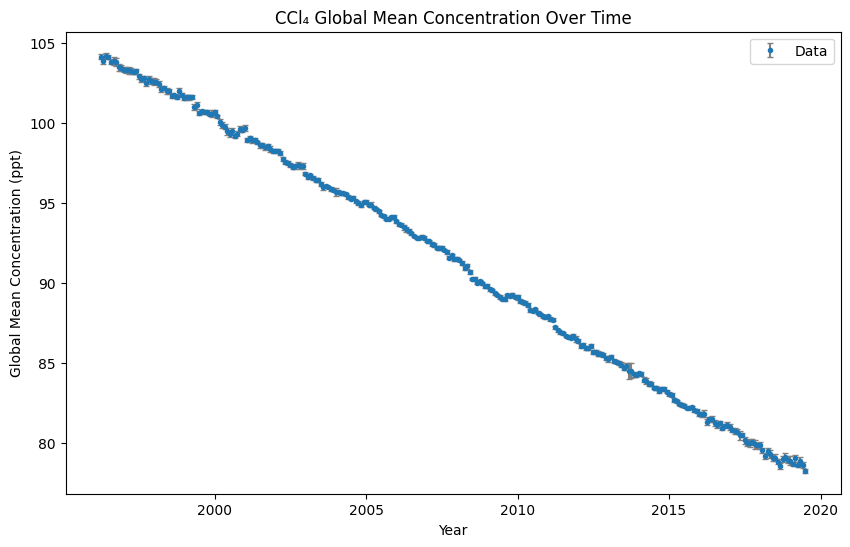

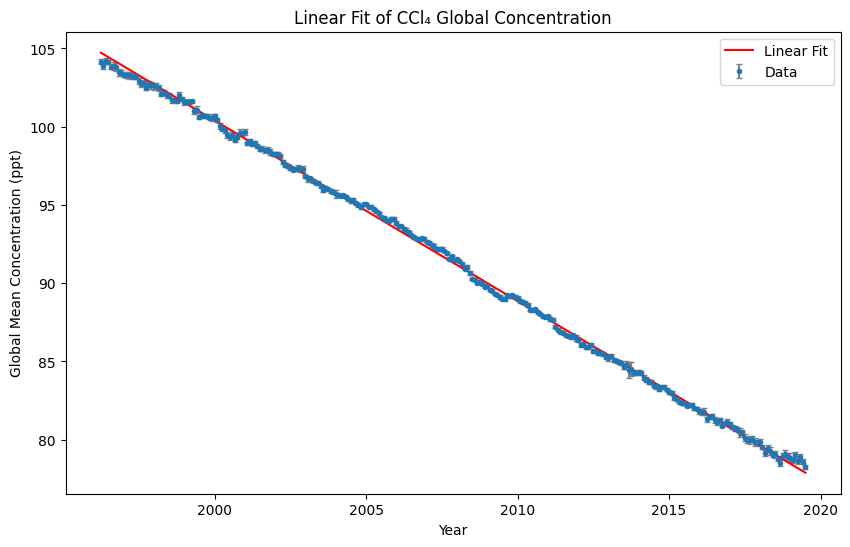


Linear Model Results:
Slope (m): -1.154410 ± 0.001281
Intercept (b): 2409.219223 ± 2.571809
Equation: f(x) = -1.154410 * x + 2409.219223
Reduced chi-squared: 4.4368


In [60]:
table = Table.read("global_CCl4_MM+(2).dat", format="ascii")
df = table.to_pandas()

df.columns = ['yr', 'mon', 'NHm', 'NHsd', 'SHm', 'SHsd', 'GLm', 'GLsd']

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=['yr', 'mon', 'GLm', 'GLsd'], inplace=True)

df['numeric_date'] = df['yr'] + (df['mon'] - 1) / 12.0

x = df['numeric_date'].values
y = df['GLm'].values
yerr = df['GLsd'].values

plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=2, markersize=3, label="Data")
plt.xlabel("Year")
plt.ylabel("Global Mean Concentration (ppt)")
plt.title("CCl₄ Global Mean Concentration Over Time")
plt.legend()
plt.show()

def linear_model(x, m, b):
    return m * x + b

popt, pcov = curve_fit(linear_model, x, y, sigma=yerr, absolute_sigma=True)
m, b = popt
m_err, b_err = np.sqrt(np.diag(pcov))

residuals = y - linear_model(x, m, b)
chi2 = np.sum((residuals / yerr) ** 2)
dof = len(x) - 2
reduced_chi2 = chi2 / dof

plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, fmt='o', ecolor='gray', capsize=2, markersize=3, label="Data")
x_fit = np.linspace(x.min(), x.max(), 500)
y_fit = linear_model(x_fit, m, b)
plt.plot(x_fit, y_fit, 'r-', label="Linear Fit")
plt.xlabel("Year")
plt.ylabel("Global Mean Concentration (ppt)")
plt.title("Linear Fit of CCl₄ Global Concentration")
plt.legend()
plt.show()

print("\nLinear Model Results:")
print(f"Slope (m): {m:.6f} ± {m_err:.6f}")
print(f"Intercept (b): {b:.6f} ± {b_err:.6f}")
print(f"Equation: f(x) = {m:.6f} * x + {b:.6f}")
print(f"Reduced chi-squared: {reduced_chi2:.4f}")